# Panoptic SAM


## Setup


Install the required libraries + code


In [1]:
!pip install x
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
x
%cd /content
!git clone --quiet https://github.com/IDEA-Research/Grounded-Segment-Anything
%cd /content/Grounded-Segment-Anything
!pip install -q -e /content/Grounded-Segment-Anything/GroundingDINO

  Preparing metadata (setup.py) ... done
/content
fatal: destination path 'Grounded-Segment-Anything' already exists and is not an empty directory.
/content/Grounded-Segment-Anything
  Preparing metadata (setup.py) ... done


Import the libraries


In [9]:
import os, sys

sys.path.append(
    os.path.join("/mnt/ve_share/liushuai/panoptic-segment-anything/GroundingDINO")
)

In [12]:
import random
import requests

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from scipy import ndimage
from PIL import Image
from huggingface_hub import hf_hub_download
from segments import SegmentsClient
from segments.export import colorize
from segments.utils import bitmap2file
from getpass import getpass

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict
from GroundingDINO.groundingdino.util.inference import annotate, predict

# segment anything
from segment_anything import build_sam, SamPredictor

# CLIPSeg
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


Download + load the Grounding DINO model


In [4]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location="cpu")
    log = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    model.to(device)
    return model


# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filename = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

groundingdino_model = load_model_hf(
    ckpt_repo_id, ckpt_filename, ckpt_config_filename, device
)

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:402: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:
/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.9/dist-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This sh

Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


Download SAM


In [5]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-04-12 16:11:05--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.10, 13.227.219.59, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  33.4MB/s    in 19s     

2023-04-12 16:11:25 (127 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



Load SAM


In [15]:
sam_checkpoint = "/mnt/ve_share/liushuai/SegmentAnyRGBD-main/sam_vit_h_4b8939.pth"
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 79.35 GiB total capacity; 1.89 GiB already allocated; 32.19 MiB free; 1.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Download + load CLIPSeg


In [7]:
clipseg_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)
clipseg_model.to(device)

## Load dataset from Segments.ai (optional)


First, create an account at [https://segments.ai/join](https://segments.ai/join?utm_source=hf&utm_medium=colab&utm_campaign=clipseg). Then you can initialize the Segments.ai Python client using your API key, which can be found on [your account page](https://segments.ai/account).


In [8]:
api_key = getpass("Enter your API key: ")
segments_client = SegmentsClient(api_key)

Enter your API key: ··········


Next, let's load the [a2d2 self-driving dataset](https://www.a2d2.audi/a2d2/en.html) using the Segments client. You can also create your own dataset by following [these instructions](https://docs.segments.ai/tutorials/getting-started).


In [9]:
dataset_identifier = "admin-tobias/panoptic-sam"

samples = segments_client.get_samples(dataset_identifier)
dataset = segments_client.get_dataset(dataset_identifier)
categories = dataset.task_attributes.categories
category_name_to_id = {category.name: category.id for category in categories}

# split the categories into "stuff" categories (regions w/o instances)
# and "thing" categories (objects/instances)
stuff_categories = [category for category in categories if not category.has_instances]
thing_categories = [category for category in categories if category.has_instances]
stuff_category_names = [category.name for category in stuff_categories]
thing_category_names = [category.name for category in thing_categories]

print("Stuff categories", stuff_category_names)
print("Thing categories", thing_category_names)

Stuff categories ['buildings', 'road', 'trees', 'sky']
Thing categories ['car', 'bus', 'person']


## Panoptic SAM


### Helper methods


In [ ]:
def download_image(url):
    return Image.open(requests.get(url, stream=True).raw)


def load_image_for_dino(image):
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    dino_image, _ = transform(image, None)
    return dino_image


def dino_detection(
    model,
    image,
    image_array,
    category_names,
    category_name_to_id,
    box_threshold,
    text_threshold,
    device,
    visualize=False,
):
    detection_prompt = " . ".join(category_names)
    dino_image = load_image_for_dino(image)
    dino_image = dino_image.to(device)
    with torch.no_grad():
        boxes, logits, phrases = predict(
            model=model,
            image=dino_image,
            caption=detection_prompt,
            box_threshold=box_threshold,
            text_threshold=text_threshold,
            device=device,
        )
    category_ids = [category_name_to_id[phrase] for phrase in phrases]

    if visualize:
        annotated_frame = annotate(
            image_source=image_array, boxes=boxes, logits=logits, phrases=phrases
        )
        annotated_frame = annotated_frame[..., ::-1]  # BGR to RGB
        visualization = Image.fromarray(annotated_frame)
        return boxes, category_ids, visualization
    else:
        return boxes, category_ids, phrases


def sam_masks_from_dino_boxes(predictor, image_array, boxes, device):
    # box: normalized box xywh -> unnormalized xyxy
    H, W, _ = image_array.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
    transformed_boxes = predictor.transform.apply_boxes_torch(
        boxes_xyxy, image_array.shape[:2]
    ).to(device)
    thing_masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    return thing_masks


def preds_to_semantic_inds(preds, threshold):
    flat_preds = preds.reshape((preds.shape[0], -1))
    # Initialize a dummy "unlabeled" mask with the threshold
    flat_preds_with_treshold = torch.full(
        (preds.shape[0] + 1, flat_preds.shape[-1]), threshold
    )
    flat_preds_with_treshold[1 : preds.shape[0] + 1, :] = flat_preds

    # Get the top mask index for each pixel
    semantic_inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape(
        (preds.shape[-2], preds.shape[-1])
    )

    return semantic_inds


def clipseg_segmentation(
    processor, model, image, category_names, background_threshold, device
):
    inputs = processor(
        text=category_names,
        images=[image] * len(category_names),
        padding="max_length",
        return_tensors="pt",
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    if len(logits.shape) == 2:
      logits = logits.unsqueeze(0)
    # resize the outputs
    upscaled_logits = nn.functional.interpolate(
        logits.unsqueeze(1),
        size=(image.size[1], image.size[0]),
        mode="bilinear",
    )
    preds = torch.sigmoid(upscaled_logits.squeeze(dim=1))
    semantic_inds = preds_to_semantic_inds(preds, background_threshold)
    return preds, semantic_inds


def semantic_inds_to_shrunken_bool_masks(
    semantic_inds, shrink_kernel_size, num_categories
):
    shrink_kernel = np.ones((shrink_kernel_size, shrink_kernel_size))

    bool_masks = torch.zeros((num_categories, *semantic_inds.shape), dtype=bool)
    for category in range(num_categories):
        binary_mask = semantic_inds == category
        shrunken_binary_mask_array = (
            ndimage.binary_erosion(binary_mask.numpy(), structure=shrink_kernel)
            if shrink_kernel_size > 0
            else binary_mask.numpy()
        )
        bool_masks[category] = torch.from_numpy(shrunken_binary_mask_array)

    return bool_masks


def clip_and_shrink_preds(semantic_inds, preds, shrink_kernel_size, num_categories):
    # convert semantic_inds to shrunken bool masks
    bool_masks = semantic_inds_to_shrunken_bool_masks(
        semantic_inds, shrink_kernel_size, num_categories
    ).to(preds.device)

    sizes = [
        torch.sum(bool_masks[i].int()).item() for i in range(1, bool_masks.size(0))
    ]
    max_size = max(sizes)
    relative_sizes = [size / max_size for size in sizes] if max_size > 0 else sizes

    # use bool masks to clip preds
    clipped_preds = torch.zeros_like(preds)
    for i in range(1, bool_masks.size(0)):
        float_mask = bool_masks[i].float()
        clipped_preds[i - 1] = preds[i - 1] * float_mask

    return clipped_preds, relative_sizes


def sample_points_based_on_preds(preds, N):
    height, width = preds.shape
    weights = preds.ravel()
    indices = np.arange(height * width)

    # Randomly sample N indices based on the weights
    sampled_indices = random.choices(indices, weights=weights, k=N)

    # Convert the sampled indices into (col, row) coordinates
    sampled_points = [(index % width, index // width) for index in sampled_indices]

    return sampled_points


def upsample_pred(pred, image_source):
    pred = pred.unsqueeze(dim=0)
    original_height = image_source.shape[0]
    original_width = image_source.shape[1]

    larger_dim = max(original_height, original_width)
    aspect_ratio = original_height / original_width

    # upsample the tensor to the larger dimension
    upsampled_tensor = F.interpolate(
        pred, size=(larger_dim, larger_dim), mode="bilinear", align_corners=False
    )

    # remove the padding (at the end) to get the original image resolution
    if original_height > original_width:
        target_width = int(upsampled_tensor.shape[3] * aspect_ratio)
        upsampled_tensor = upsampled_tensor[:, :, :, :target_width]
    else:
        target_height = int(upsampled_tensor.shape[2] * aspect_ratio)
        upsampled_tensor = upsampled_tensor[:, :, :target_height, :]
    return upsampled_tensor.squeeze(dim=1)


def sam_mask_from_points(predictor, image_array, points):
    points_array = np.array(points)
    # we only sample positive points, so labels are all 1
    points_labels = np.ones(len(points))
    # we don't use predict_torch here cause it didn't seem to work...
    masks, scores, logits = predictor.predict(
        point_coords=points_array,
        point_labels=points_labels,
    )
    # max over the 3 segmentation levels
    total_pred = torch.max(torch.sigmoid(torch.tensor(logits)), dim=0)[0].unsqueeze(
        dim=0
    )
    # logits are 256x256 -> upsample back to image shape
    upsampled_pred = upsample_pred(total_pred, image_array)
    return upsampled_pred

### Panoptic SAM pipeline


The next method defines the full pipeline for a single image input.


Let's download an image and try it out!
Uncomment and run the second cell if you didn't load a dataset from Segments.ai.


In [ ]:
sample = samples[0]
image_url = sample.attributes.image.url

In [ ]:
# image_url = "https://segmentsai-prod.s3.eu-west-2.amazonaws.com/assets/admin-tobias/996f3571-66d8-4dfd-8c1a-402d7c0c820b.png"
# thing_category_names = ["car", "person", "bus"]
# stuff_category_names = ["building", "road", "sky", "trees", "sidewalk"]
# category_names = thing_category_names + stuff_category_names
# category_name_to_id = {
#     category_name: i for i, category_name in enumerate(category_names)
# }

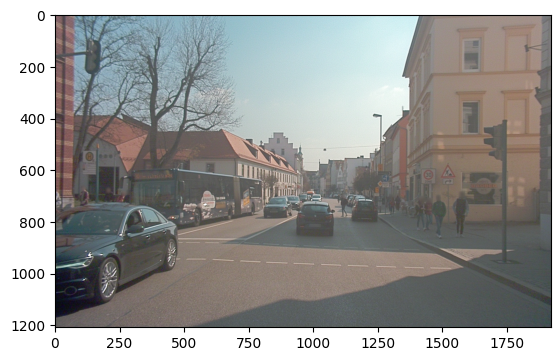

In [12]:
image = download_image(image_url)
plt.imshow(image)

Running the whole pipeline takes less than 10 seconds on Google Colab (in a GPU runtime). On CPU, it takes around 2 minutes.


In [13]:
panoptic_inds, thing_category_ids = generate_panoptic_mask(
    image,
    thing_category_names,
    stuff_category_names,
    category_name_to_id,
    groundingdino_model,
    sam_predictor,
    clipseg_processor,
    clipseg_model,
    device,
)

/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:830: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


We can visualize the panoptic segmentation result by colorizing the masks and overlaying them on the image.


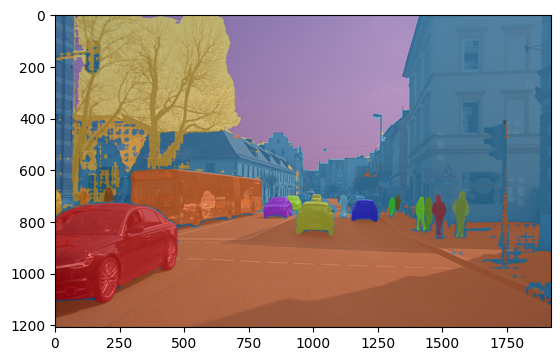

In [14]:
_, ax = plt.subplots()
ax.imshow(image)
ax.imshow(colorize(panoptic_inds), alpha=0.5)

Lastly, we can upload the prediction to Segments.ai. To do that, we'll first convert the `panoptic_inds` tensor to a png file, then we'll upload this file to the Segments, and finally we'll add the label to the sample.


In [15]:
def inds_to_segments_format(
    panoptic_inds, thing_category_ids, stuff_category_names, category_name_to_id
):
    panoptic_inds_array = panoptic_inds.numpy().astype(np.uint32)
    bitmap_file = bitmap2file(panoptic_inds_array, is_segmentation_bitmap=True)

    stuff_category_ids = [
        category_name_to_id[stuff_category_name]
        for stuff_category_name in stuff_category_names
    ]

    unique_inds = np.unique(panoptic_inds_array)
    stuff_annotations = [
        {"id": i, "category_id": stuff_category_ids[i - 1]}
        for i in range(1, len(stuff_category_names) + 1)
        if i in unique_inds
    ]
    thing_annotations = [
        {"id": len(stuff_category_names) + 1 + i, "category_id": thing_category_id}
        for i, thing_category_id in enumerate(thing_category_ids)
    ]
    annotations = stuff_annotations + thing_annotations

    return bitmap_file, annotations


def upload_label(
    panoptic_inds,
    thing_category_ids,
    stuff_category_names,
    category_name_to_id,
    segments_client,
    sample,
):
    bitmap_file, annotations = inds_to_segments_format(
        panoptic_inds, thing_category_ids, stuff_category_names, category_name_to_id
    )

    asset = segments_client.upload_asset(bitmap_file, "panoptic_sam_prediction.png")

    attributes = {
        "format_version": "0.1",
        "annotations": annotations,
        "segmentation_bitmap": {"url": asset.url},
    }

    segments_client.add_label(sample.uuid, "ground-truth", attributes)

In [16]:
upload_label(
    panoptic_inds,
    thing_category_ids,
    stuff_category_names,
    category_name_to_id,
    segments_client,
    sample,
)

## Run Panoptic SAM on the whole dataset


In [16]:
for sample in samples:
    image = download_image(sample.attributes.image.url)
    panoptic_inds, thing_category_ids = generate_panoptic_mask(
        image,
        thing_category_names,
        stuff_category_names,
        category_name_to_id,
        groundingdino_model,
        sam_predictor,
        clipseg_processor,
        clipseg_model,
        device,
    )
    upload_label(
        panoptic_inds,
        thing_category_ids,
        stuff_category_names,
        category_name_to_id,
        segments_client,
        sample,
    )

NameError: name 'samples' is not defined

## Visualizations of the different pipeline steps


Let's first define some visualization methods to help us see what's going on in the pipeline.


In [18]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_segmentation_preds(preds, category_names):
    len_cats = len(category_names)
    _, ax = plt.subplots(1, len_cats + 1, figsize=(3 * (len_cats + 1), 4))
    [a.axis("off") for a in ax.flatten()]
    ax[0].imshow(image)
    [ax[i + 1].imshow(preds[i].cpu()) for i in range(len_cats)]
    [
        ax[i + 1].text(0, -15, category_name)
        for i, category_name in enumerate(category_names)
    ]

Input image


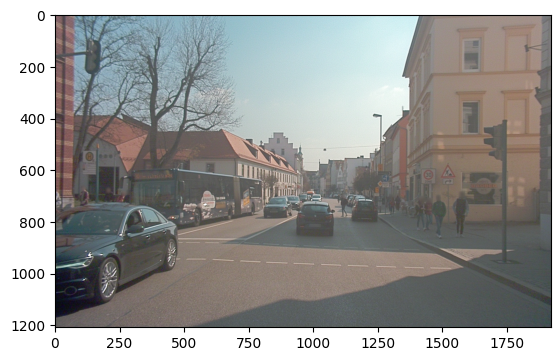

In [19]:
image = image.convert("RGB")
image_array = np.asarray(image)
plt.imshow(image_array)

Boxes for "thing" categories from Grounding DINO


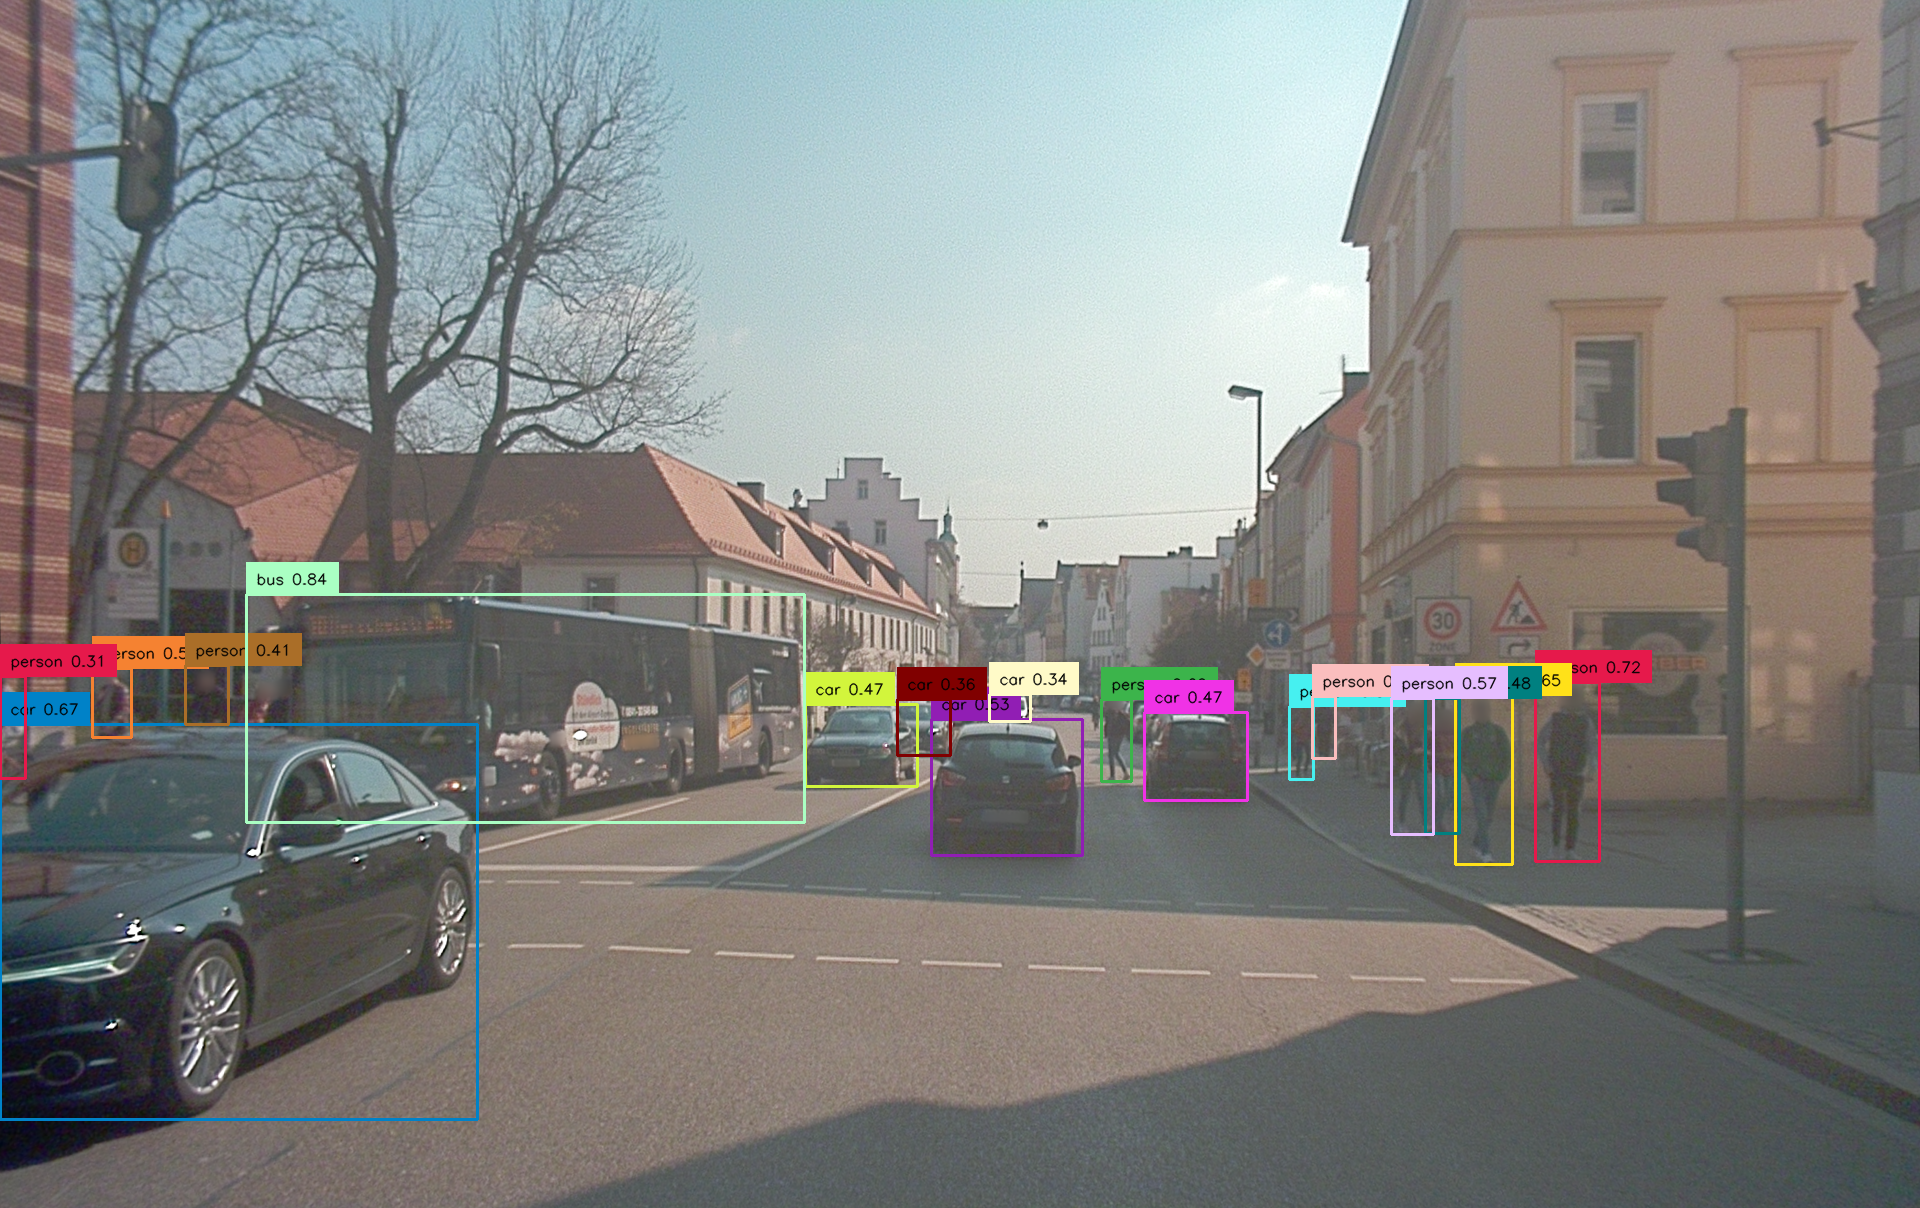

In [20]:
dino_box_threshold = 0.3
dino_text_threshold = 0.25

thing_boxes, thing_category_ids, visualization = dino_detection(
    groundingdino_model,
    image,
    image_array,
    thing_category_names,
    category_name_to_id,
    dino_box_threshold,
    dino_text_threshold,
    device,
    visualize=True,
)
visualization

Segmentation masks for the thing boxes from SAM


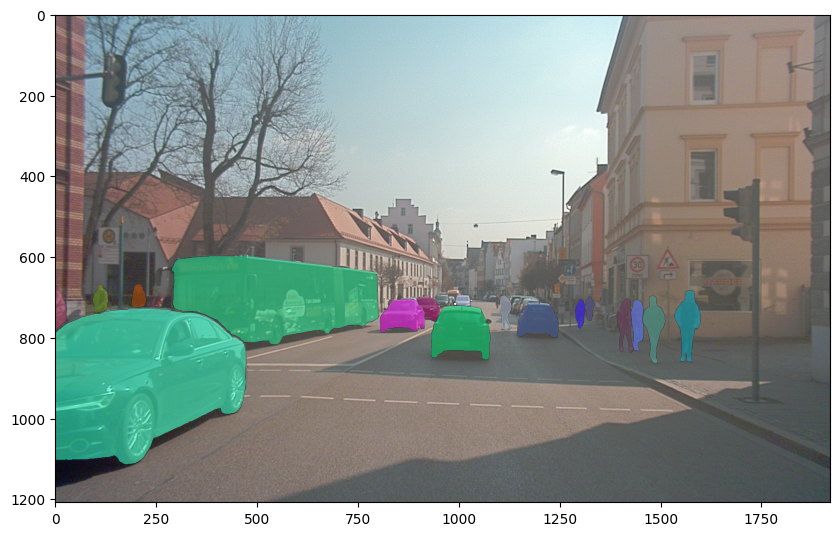

In [21]:
# compute SAM image embedding
sam_predictor.set_image(image_array)
thing_masks = sam_masks_from_dino_boxes(sam_predictor, image_array, thing_boxes, device)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for thing_mask in thing_masks:
    show_mask(thing_mask.cpu().numpy(), plt.gca(), random_color=True)

CLIPSeg predictions for the "stuff" categories


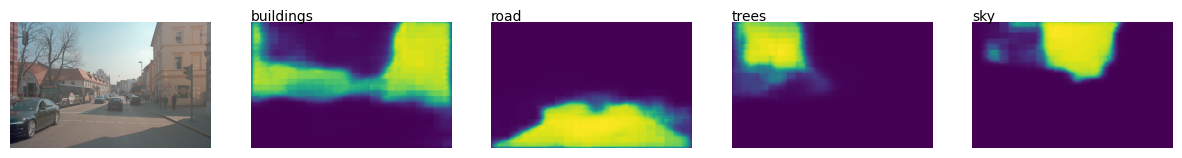

In [22]:
segmentation_background_threshold = 0.1

# get rough segmentation masks for "stuff" categories using CLIPSeg
clipseg_preds, clipseg_semantic_inds = clipseg_segmentation(
    clipseg_processor,
    clipseg_model,
    image,
    stuff_category_names,
    segmentation_background_threshold,
    device,
)
show_segmentation_preds(clipseg_preds, stuff_category_names)

Integrated semantic segmentation output from CLIPSeg


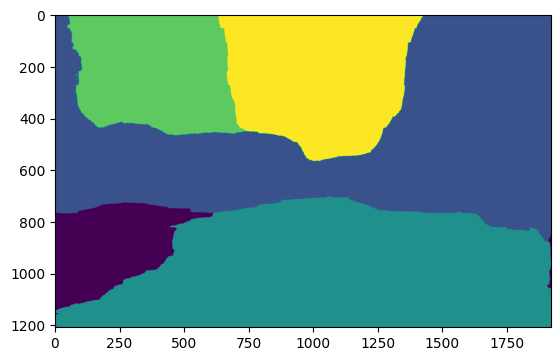

In [23]:
plt.imshow(clipseg_semantic_inds)

Clipped and shrunken CLIPSeg preds based on the integrated segmentation map


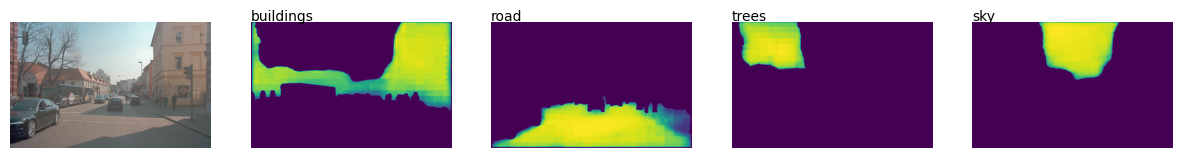

In [24]:
# remove things from stuff masks
clipseg_semantic_inds_without_things = clipseg_semantic_inds.clone()
if len(thing_boxes > 0):
    combined_things_mask = torch.any(thing_masks, dim=0)
    clipseg_semantic_inds_without_things[combined_things_mask[0]] = 0
# clip CLIPSeg preds based on non-overlapping semantic segmentation inds (+ optionally shrink the mask of each category)
# also returns the relative size of each category
shrink_kernel_size = 20
clipsed_clipped_preds, relative_sizes = clip_and_shrink_preds(
    clipseg_semantic_inds_without_things,
    clipseg_preds,
    shrink_kernel_size,
    len(stuff_category_names) + 1,
)
show_segmentation_preds(clipsed_clipped_preds, stuff_category_names)

Let's use SAM to refine the segmentation mask of one of the categories.


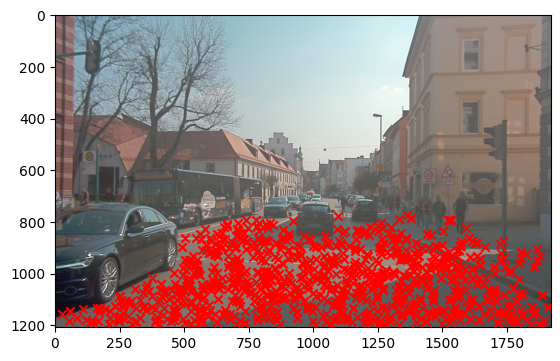

In [25]:
i = 1
clipseg_pred = clipsed_clipped_preds[i]
# for each "stuff" category, sample points in the rough segmentation mask
num_samples_factor = 1000
num_samples = int(relative_sizes[i] * num_samples_factor)
points = sample_points_based_on_preds(clipseg_pred.cpu().numpy(), num_samples)

_, ax = plt.subplots()
ax.imshow(image)
x_coords, y_coords = zip(*points)
ax.scatter(x_coords, y_coords, color="red", marker="x")

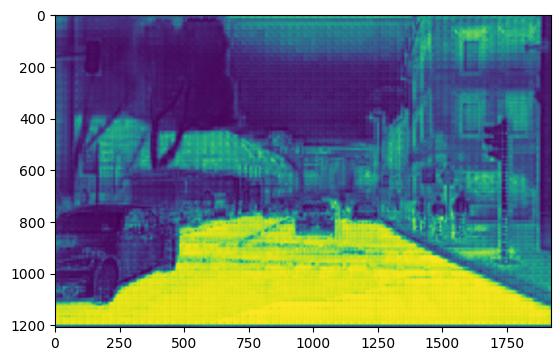

In [26]:
# use SAM to get mask for points
pred = sam_mask_from_points(sam_predictor, image_array, points)
plt.imshow(pred.squeeze(dim=0))